In [1]:
import pandas as pd

target_path = 'Targets/daily_crsp_sanitized.csv'

In [2]:
daily = pd.read_csv(target_path, nrows=100000)
daily.head()

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
0,2000-01-03,5,15580,6320,0,0.000000,-0.009549
1,2000-01-03,7,14593,3573,0,0.088754,-0.009549
2,2000-01-03,25,62770,6711,0,-0.061489,-0.009549
3,2000-01-03,29,59184,2082,0,-0.012346,-0.009549
4,2000-01-03,33,59248,2082,0,-0.034524,-0.009549


In [3]:
daily.tail()

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn
99995,2000-01-19,34961,86476,6726,0,0.005405,0.000522
99996,2000-01-19,34961,86477,6726,0,-0.005618,0.000522
99997,2000-01-19,34961,86478,6726,0,0.015000,0.000522
99998,2000-01-19,34961,86479,6726,0,0.014634,0.000522
99999,2000-01-19,34961,86480,6726,0,0.010363,0.000522


In [4]:
window_size = 5  # number of past days to use

# Create lagged features for each stock
df_lagged = daily[['date', 'PERMNO', 'DlyRet']].copy()

for lag in range(1, window_size + 1):
    df_lagged[f'ret_lag{lag}'] = df_lagged.groupby('PERMNO')['DlyRet'].shift(lag)

# Drop rows with NaNs due to lagging
df_lagged = df_lagged.dropna()

# Inputs: ret_lag1, ..., ret_lag5
# Target: DlyRet (next-day return)
feature_cols = [f'ret_lag{i}' for i in range(1, window_size + 1)]
X = df_lagged[feature_cols].values
y = df_lagged['DlyRet'].values


In [5]:
# Use same chronological split logic as before
df_lagged = df_lagged.reset_index(drop=True).sort_values('date')
unique_dates = df_lagged['date'].unique()
n_train = int(len(unique_dates) * 2 / 3)

train_dates = unique_dates[:n_train]
test_dates = unique_dates[n_train:]

train_df = df_lagged[df_lagged['date'].isin(train_dates)]
test_df = df_lagged[df_lagged['date'].isin(test_dates)]

X_train = train_df[feature_cols].values
y_train = train_df['DlyRet'].values

X_test = test_df[feature_cols].values
y_test = test_df['DlyRet'].values


In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)


In [7]:
import torch.nn as nn

class ReturnForecaster(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

model = ReturnForecaster(input_dim=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(20):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # Optional evaluation
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor)
        mse = loss_fn(preds, y_test_tensor)
        print(f"Epoch {epoch}: Test MSE = {mse.item():.6f}")


Epoch 0: Test MSE = 0.003661
Epoch 1: Test MSE = 0.003638
Epoch 2: Test MSE = 0.003661
Epoch 3: Test MSE = 0.003636
Epoch 4: Test MSE = 0.003596
Epoch 5: Test MSE = 0.003620
Epoch 6: Test MSE = 0.003603
Epoch 7: Test MSE = 0.003606
Epoch 8: Test MSE = 0.003634
Epoch 9: Test MSE = 0.003602
Epoch 10: Test MSE = 0.003618
Epoch 11: Test MSE = 0.003594
Epoch 12: Test MSE = 0.003613
Epoch 13: Test MSE = 0.003624
Epoch 14: Test MSE = 0.003583
Epoch 15: Test MSE = 0.003589
Epoch 16: Test MSE = 0.003653
Epoch 17: Test MSE = 0.003589
Epoch 18: Test MSE = 0.003637
Epoch 19: Test MSE = 0.003601


In [8]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_true_test = y_test_tensor.numpy()


In [9]:
import numpy as np

# Daily strategy return = signal * actual return
strategy_returns = y_pred_test * y_true_test

# Get dates from test_df (aligned with y_test)
dates_test = test_df['date'].values

# Combine into DataFrame
strategy_df = pd.DataFrame({
    'date': dates_test,
    'strategy_ret': strategy_returns
})

# Group by date to compute daily PnL across all stocks
daily_returns = strategy_df.groupby('date')['strategy_ret'].sum()

# Sharpe Ratio calculation
mean_ret = daily_returns.mean()
std_ret = daily_returns.std()
sharpe_ratio = mean_ret / (std_ret + 1e-8)

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Sharpe Ratio: 3.4075


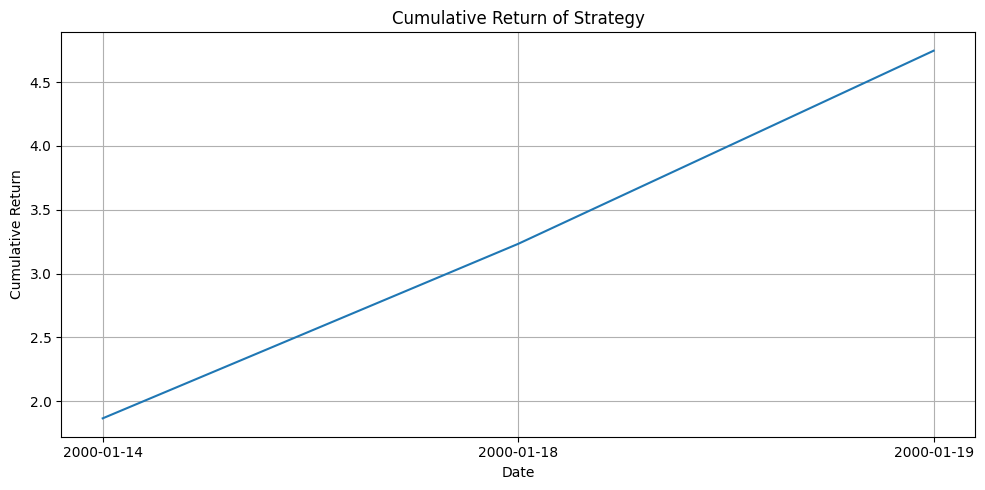

In [10]:
import matplotlib.pyplot as plt

# Compute cumulative return
cumulative_returns = (1 + daily_returns).cumprod()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns.index, cumulative_returns.values)
plt.title("Cumulative Return of Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()
